In [1]:
%load_ext jupyter_black

2022-12-06

TX and TN groups were added to the header of the training data, and the model was retrained.

because the model reads left to right and the temperature groups serve as a loose classifier, the model will be more likely have a higher confidence in predicting present weather IE: RA, SN, etc. when the temperature is below freezing.


In [2]:
from pathlib import Path
import pandas as pd

In [3]:
df = pd.concat(
    pd.read_json(path, lines=True) for path in Path("store/results").glob("*.json")
)
df

,prompt,completion,strategy
0,TAF [TX20 TN13] AMD KDAA 251400Z 2514/2616 VRB...,OVC010 WS020/20038KT 510203 QNH2981INS\nBECMG...,TEMP_095
1,TAF [TX08 TN02] AMD KHOP 151230Z 1512/1614 230...,QNH3006INS\nBECMG 1419/1420 33010G15KT 9999 N...,TEMP_095
2,TAF [TXM03 TNM08] AMD KRDR 141452Z 1414/1516,30006KT 9999 NSW BKN007 OVC015 620079 QNH3028...,TEMP_095
3,TAF [TX26 TN15] KFTK 041900Z 0419/0601 18012G2...,BKN009 510109 QNH2980INS\nBECMG 0508/0509 180...,TEMP_095
4,TAF [TX21 TN14] KFAF 031000Z 0310/0416 04006KT...,OVC012 WS020/20037KT 510203 QNH2937INS\nBECMG...,TEMP_095
...,...,...,...
35,TAF [TX24 TN19] AMD KLFI 111128Z 1111/1215,18015G35KT cells Sierra Kub 2035MachINS Close...,TEMP_200
36,TAF [TXM13 TNM24] PAFB 010600Z 0106/0212 VRB03...,33010KT Coordinator SH090 BKN13 620444 QNH29T...,TEMP_200
37,TAF [TX26 TN07] KDAA 071200Z 0712/0818 VRB06KT,9999 SOUSunday78 Huangzy Fletcher 03015Az040 ...,TEMP_200
38,TAF [TX02 TNM04] AMD KBLV 161934Z 1619/1722 28...,6580925 QNH2972INS\nTEMPO 1620/1600 9000 BR F...,TEMP_200


In [4]:
icao_pattern = r"""
(?x)                # verbose mode
^.*                 # beginning any character
\s                  # whitespace
(?P<icao>[A-Z]{4})  # 4 capital letters
\s                  # whitespace
"""
# extract the station identifier
df["icao"] = df.prompt.str.extract(icao_pattern)

temperature_pattern = r"""
(?x)                  # verbose mode
(?:TX)(?P<TX>M?\d{2}) # TX followed by 2 digits, optionally preceded by M
.+                    # any character
(?:TN)(?P<TN>M?\d{2}) # TN followed by 2 digits, optionally preceded by M
"""
# extract the temperatures
def extract_temperatures(s: pd.Series) -> pd.DataFrame:
    df = (
        s.str.extract(temperature_pattern)
        # add the series name as a prefix to the column names
        .add_prefix(f"{s.name}_")
        # replace M with - and convert to float
        .apply(lambda s: s.str.replace("M", "-")).astype(float)
    )
    return df


df = pd.concat(
    [
        df,
        df.prompt.pipe(extract_temperatures),
        df.completion.pipe(extract_temperatures),
    ],
    axis=1,
).set_index(["strategy", "icao"])
df  # type: ignore

prompt  \
strategy icao                                                      
TEMP_095 KDAA  TAF [TX20 TN13] AMD KDAA 251400Z 2514/2616 VRB...   
         KHOP  TAF [TX08 TN02] AMD KHOP 151230Z 1512/1614 230...   
         KRDR       TAF [TXM03 TNM08] AMD KRDR 141452Z 1414/1516   
         KFTK  TAF [TX26 TN15] KFTK 041900Z 0419/0601 18012G2...   
         KFAF  TAF [TX21 TN14] KFAF 031000Z 0310/0416 04006KT...   
...                                                          ...   
TEMP_200 KLFI         TAF [TX24 TN19] AMD KLFI 111128Z 1111/1215   
         PAFB  TAF [TXM13 TNM24] PAFB 010600Z 0106/0212 VRB03...   
         KDAA     TAF [TX26 TN07] KDAA 071200Z 0712/0818 VRB06KT   
         KBLV  TAF [TX02 TNM04] AMD KBLV 161934Z 1619/1722 28...   
         PAFB  TAF [TXM09 TNM13] PAFB 151500Z 1515/1621 VRB03...   

                                                      completion  prompt_TX  \
strategy icao                                                                 
TEMP_095 KDAA   OVC010 WS020/20038KT 510203 QNH2981INS\nBECMG...       20.0   
         KHOP   QNH3006INS\nBECMG 1419/1420 33010G15KT 9999 N...        8.0   
         KRDR   30006KT 9999 NSW BKN007 OVC015 620079 QNH3028...       -3.0   
         KFTK   BKN009 510109 QNH2980INS\nBECMG 0508/0509 180...       26.0   
         KFAF   OVC012 WS020/20037KT 510203 QNH2937INS\nBECMG...       21.0   
...                                                          ...        ...   
TEMP_200 KLFI   18015G35KT cells Sierra Kub 2035MachINS Close...       24.0   
         PAFB   33010KT Coordinator SH090 BKN13 620444 QNH29T...      -13.0   
         KDAA   9999 SOUSunday78 Huangzy Fletcher 03015Az040 ...       26.0   
         KBLV   6580925 QNH2972INS\nTEMPO 1620/1600 9000 BR F...        2.0   
         PAFB   630306 detonria 0125/0128 quant examination a...       -9.0   

               prompt_TN  completion_TX  completion_TN  
strategy icao                                           
TEMP_095 KDAA       13.0           20.0           13.0  
         KHOP        2.0            8.0            2.0  
         KRDR       -8.0           -3.0           -8.0  
         KFTK       15.0           26.0           15.0  
         KFAF       14.0           21.0           14.0  
...                  ...            ...            ...  
TEMP_200 KLFI       19.0            NaN            NaN  
         PAFB      -24.0           21.0          -23.0  
         KDAA        7.0           26.0            7.0  
         KBLV       -4.0            NaN            NaN  
         PAFB      -13.0            NaN            NaN  

[840 rows x 6 columns]

In [5]:
# calculate the absolute difference between the prompt and completion temperatures
df["delta_TX"] = (df.prompt_TX - df.completion_TX).abs()
df["delta_TN"] = (df.prompt_TN - df.completion_TN).abs()
# sum the absolute differences for TX and TN
df["delta"] = df.delta_TX + df.delta_TN
df.describe()  # show some statistics

,prompt_TX,prompt_TN,completion_TX,completion_TN,delta_TX,delta_TN,delta
count,840.000000,840.00000,798.000000,798.000000,798.000000,798.000000,798.000000
mean,8.975000,0.70000,8.948622,0.548872,1.150376,0.511278,1.661654
std,11.562159,10.44461,11.510450,10.680932,3.986482,1.987223,5.129520
min,-13.000000,-24.00000,-35.000000,-29.000000,0.000000,0.000000,0.000000
25%,0.500000,-4.75000,1.000000,-6.750000,0.000000,0.000000,0.000000
50%,10.000000,2.00000,9.000000,2.000000,0.000000,0.000000,0.000000
75%,19.250000,9.00000,19.000000,9.000000,0.000000,0.000000,1.000000
max,26.000000,19.00000,26.000000,26.000000,35.000000,22.000000,48.000000


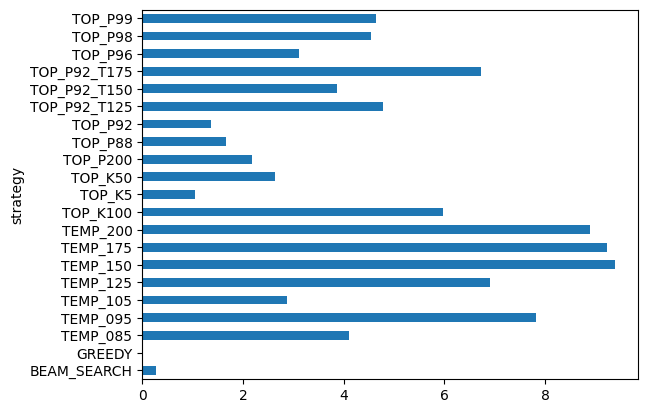

In [6]:
# horizontal bar chart of the standard deviation of the absolute difference; lower is better
ax = df.delta.groupby("strategy").std().plot.barh()

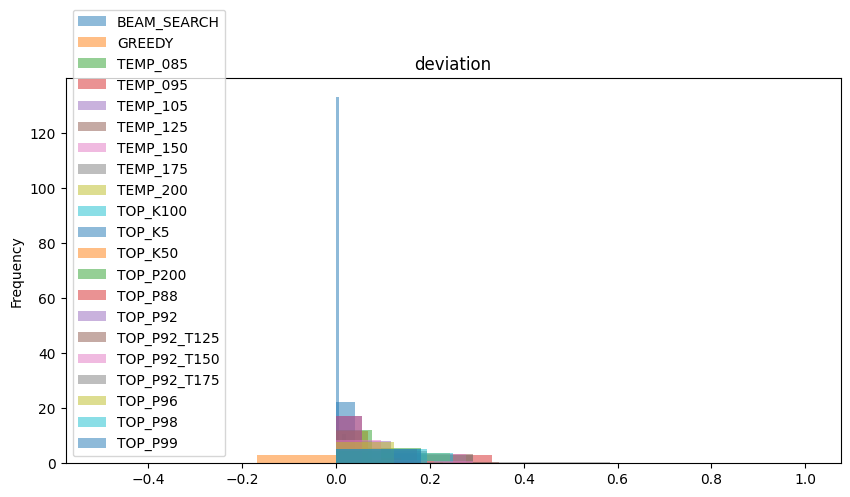

In [7]:
# normalize the DataFrame delta by the maximum temperature deviation
# and drop the rows with no deviation as they are the overwhelming majority of the samples
normalized = df.delta.div(df.delta.abs().max())
# plot a distribution of the of the deviation labeled by the strategy
hist = normalized.groupby("strategy").plot.hist(
    title="deviation",
    bins=3,
    alpha=0.5,
    legend={"loc": "best"},
    figsize=(10, 5),
    density=True,
)

<AxesSubplot: ylabel='strategy'>

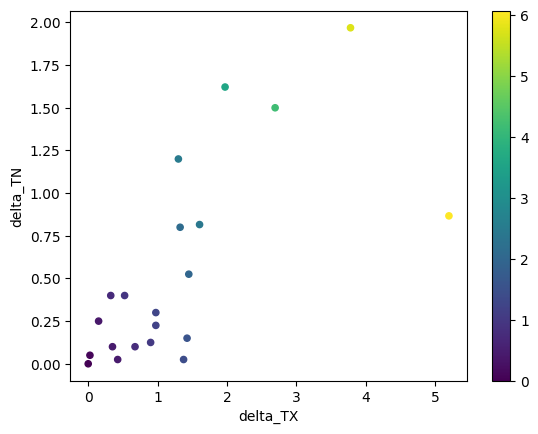

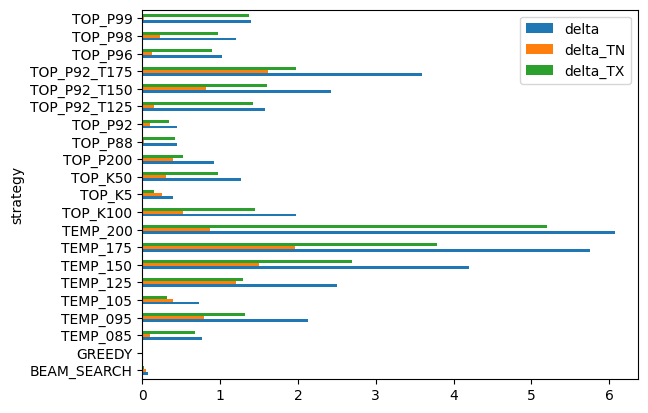

In [8]:
strategy_group = (
    df.loc[:, df.columns.str.contains("delta")]
    .reset_index("icao")
    .drop("icao", axis=1)
    .dropna(how="all", axis=0)
)
pt = strategy_group.pivot_table(index="strategy", aggfunc="mean")

pt.plot.scatter("delta_TX", "delta_TN", c=pt.delta.to_numpy(), colormap="viridis")
pt.plot.barh()

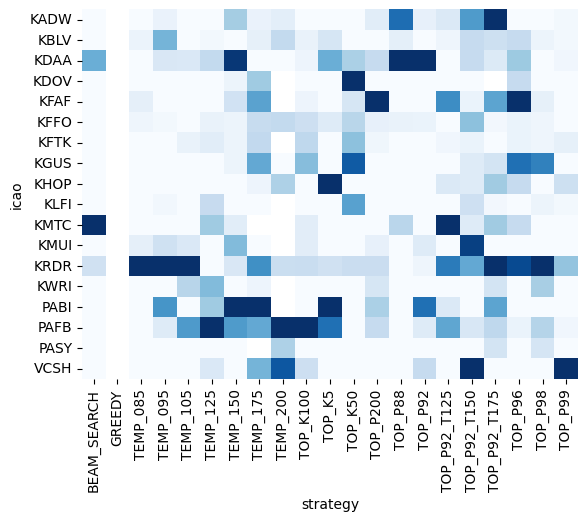

In [9]:
import seaborn as sns


def plot_heatmap(df: pd.DataFrame, title: str):
    # df = df.pivot_table(index="icao", columns="strategy", values="delta")
    # df = df.where(df < 20).dropna()
    df = df / df.max()
    sns.heatmap(df, cmap="Blues", cbar=False)


df.pivot_table(index="icao", columns="strategy", values="delta").pipe(
    plot_heatmap, "Temperature deviation"
)

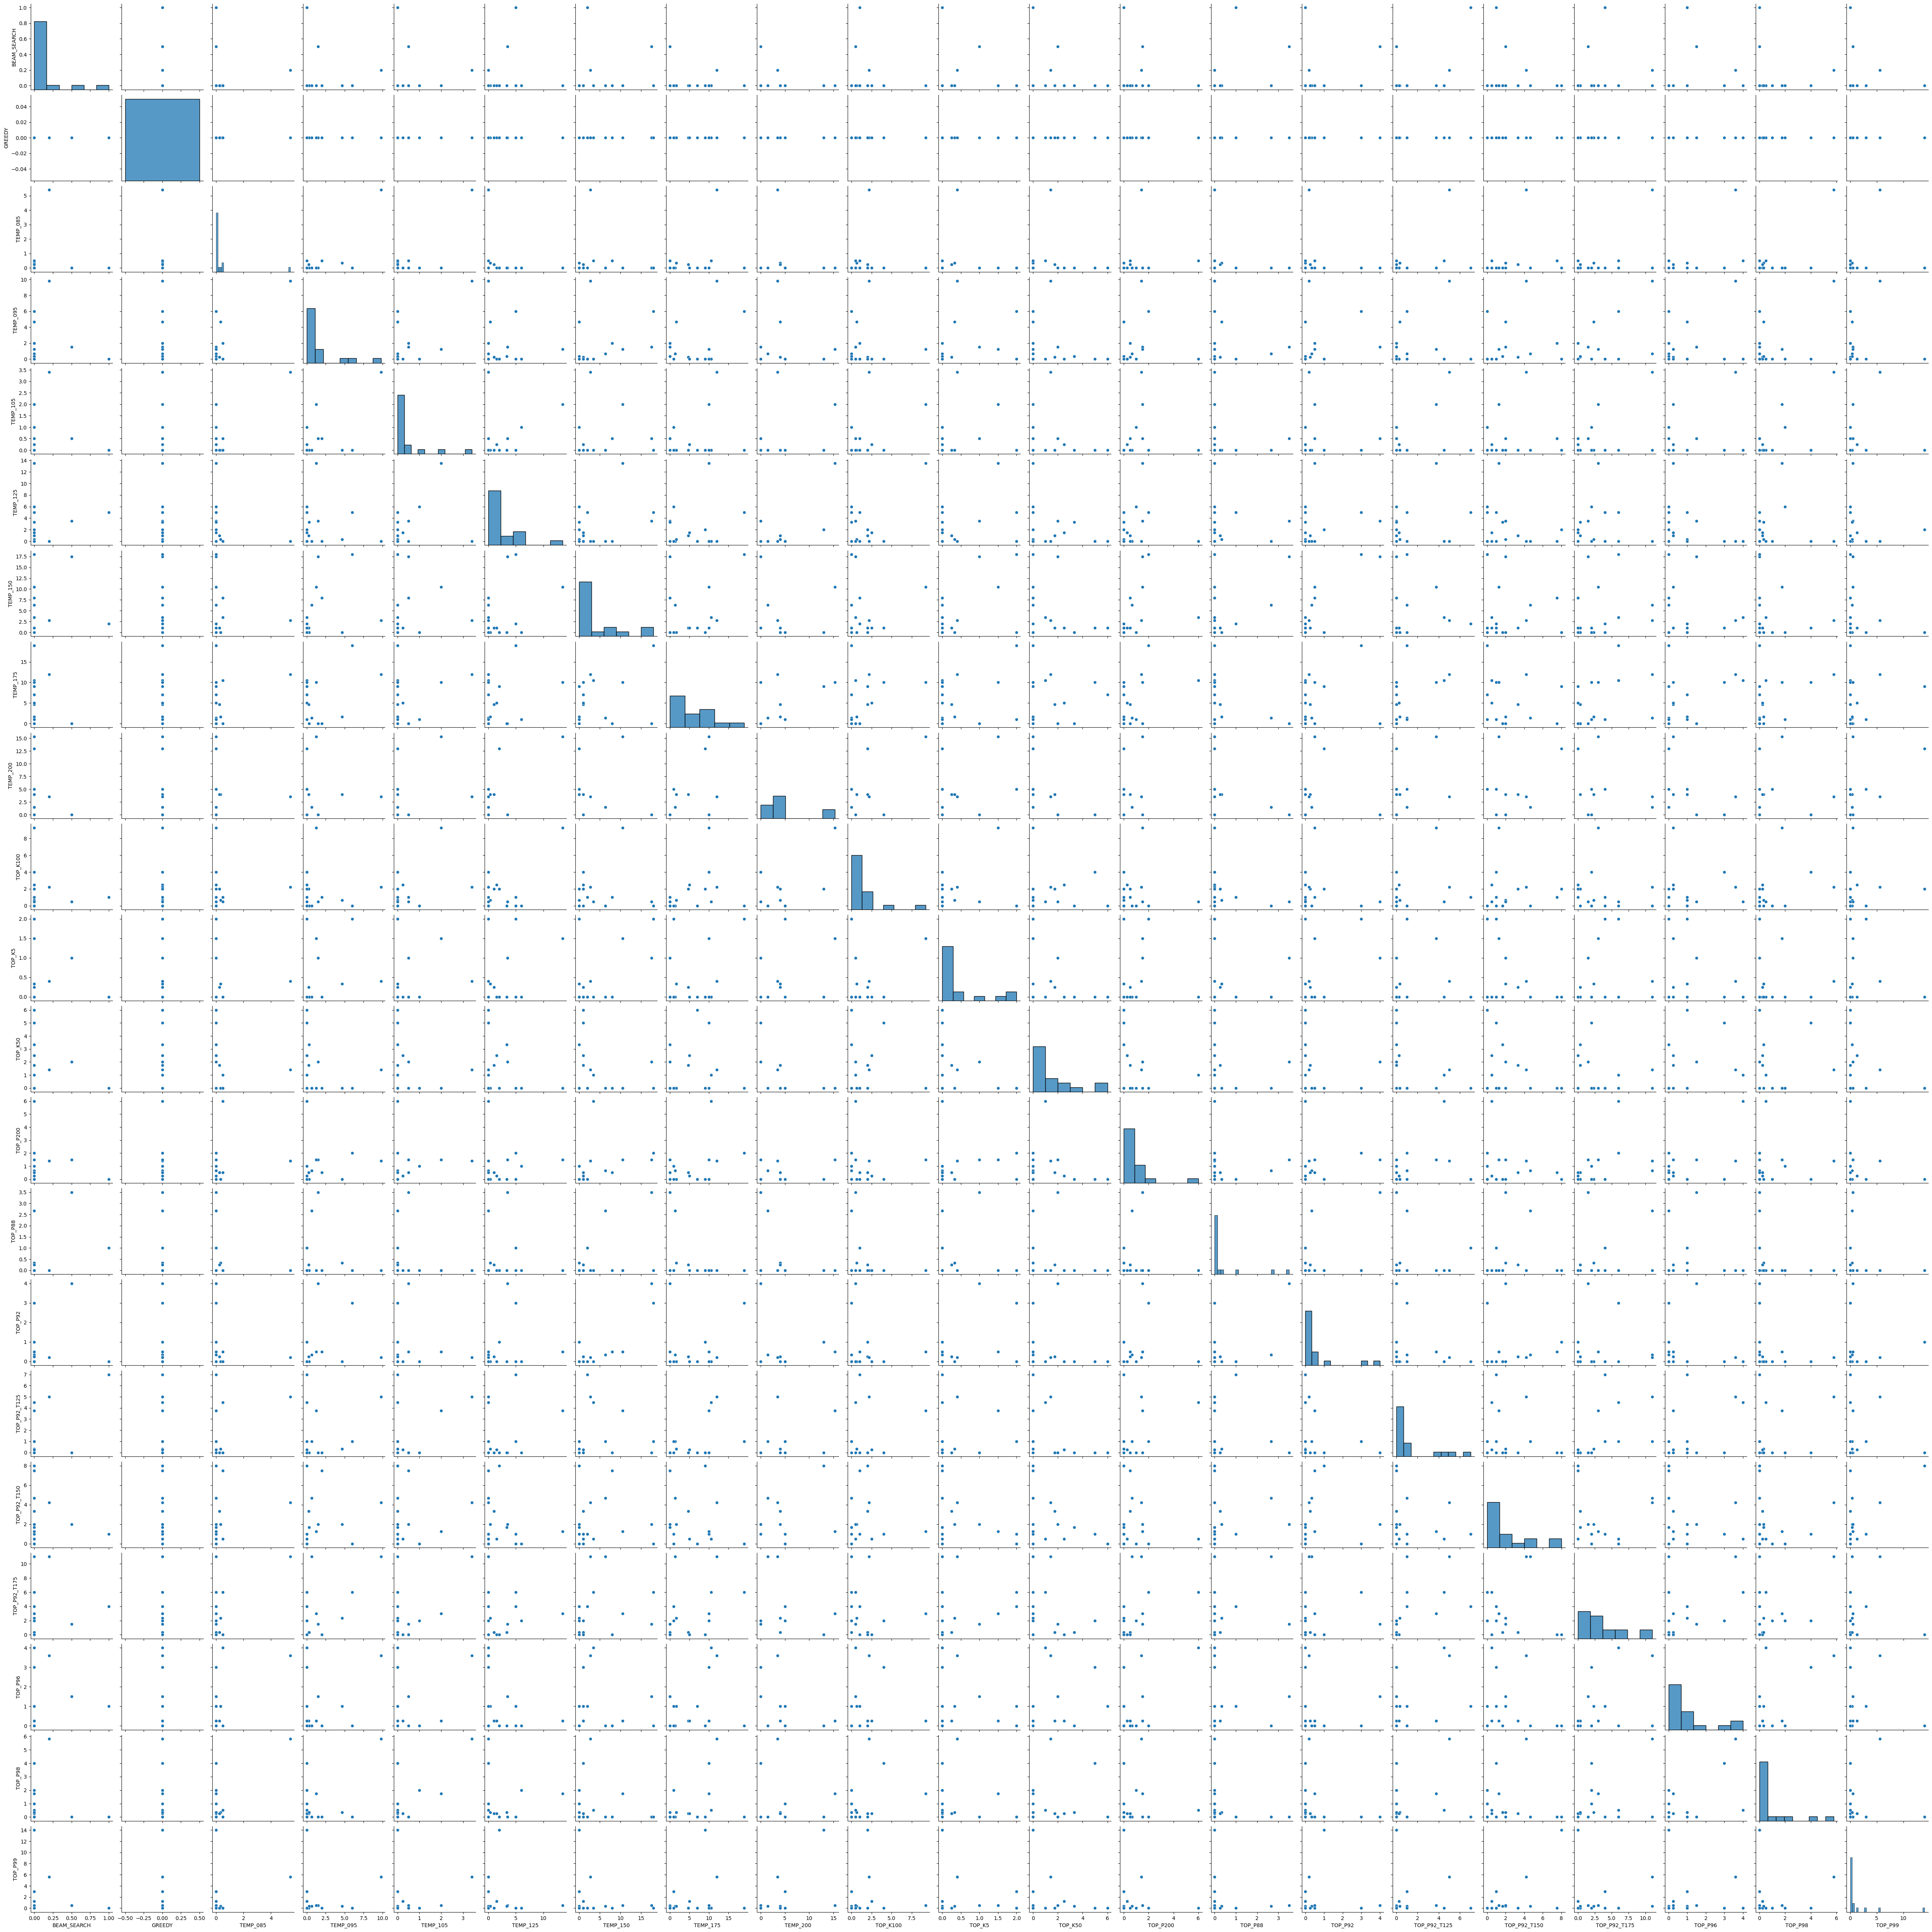

In [13]:
df.pivot_table(index="icao", columns="strategy", values="delta").pipe(sns.pairplot)

<AxesSubplot: xlabel='strategy'>

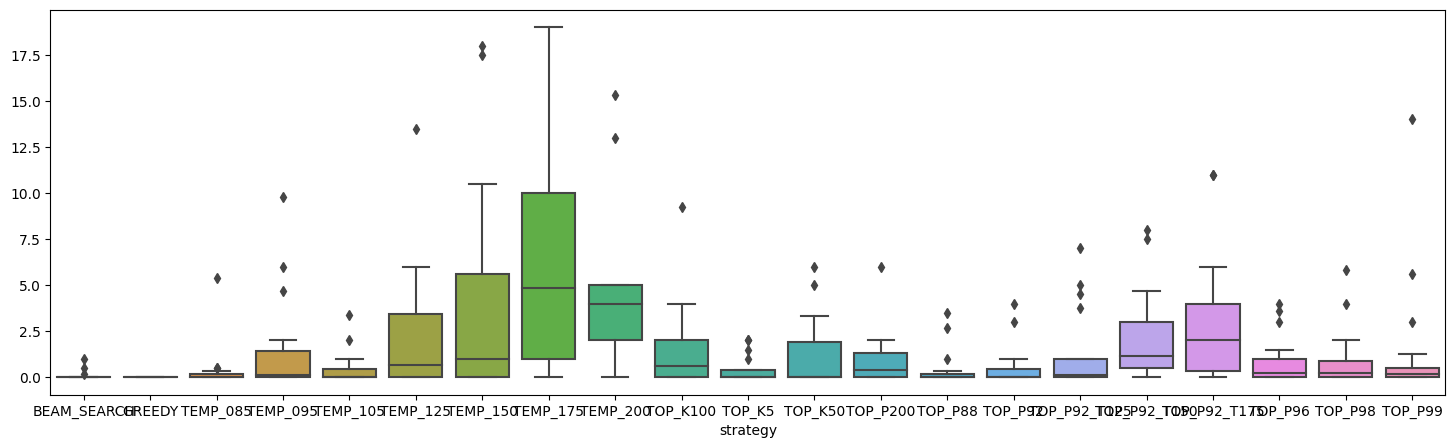

In [44]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(18, 5))

df.pivot_table(index="icao", columns="strategy", values="delta").pipe(
    sns.boxplot, ax=ax
)

In [11]:
for index, frame in df.sample(20).iterrows():
    print(
        (frame.prompt + "... " + frame.completion),
        frame[
            [
                "prompt_TX",
                "completion_TX",
                "delta_TX",
                "prompt_TN",
                "completion_TN",
                "delta_TN",
            ]
        ],
        sep="\n",
    )
    print()

TAF [TXM04 TNM13] KRDR 151000Z 1510/1616 35006KT 9999...  FEW004 BKN012 WS020/20039KT 510203 QNH3020INS
BECMG 1521/1522 VRB06KT 9000 -SHRA OVC015 WS020/20037KT 510203 QNH3010INS
BECMG 1602/1603 VRB06KT 9999 NSW OVC020 QNH3010INS TXM04/1521Z TNM13/1613Z
prompt_TX        -4.0
completion_TX    -4.0
delta_TX          0.0
prompt_TN       -13.0
completion_TN   -13.0
delta_TN          0.0
Name: (TOP_P92_T125, KRDR), dtype: object

TAF [TX20 TN08] KMUI 021100Z 0211/0317 VRB06KT 9999 SCT015...  BKN025 OVC050 QNH2960INS
BECMG 0213/0214 18008KT 6000 -RA OVC008 QNH2962INS
BECMG 0223/0224 VRB06KT 8000 BR SCT015 OVC025 QNH2975INS
BECMG 0314/0315 18008KT 4800 BR BKN015 OVC030 QNH2978INS
BECMG 0318/0319 VRB06KT 9999 NSW FEW020 QNH2979INS
BECMG 0205/0206 VRB06KT 9999 BKN035 QNH2991INS
BECMG 0611/0612 VRB06KT 9999 SCT080 QNH3001INS TX20/0320Z TN08/0611Z
prompt_TX        20.0
completion_TX    20.0
delta_TX          0.0
prompt_TN         8.0
completion_TN     8.0
delta_TN          0.0
Name: (TOP_P200, KMU